In [9]:
#Reference : https://www.tensorflow.org/tutorials/images/transfer_learning

In [10]:
#import the required libraries and functions
#wandb code can be uncommented  
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import math

In [11]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2021-04-13 11:53:47--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  34.2MB/s    in 65s     

2021-04-13 11:54:52 (56.3 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [12]:
!unzip -q nature_12K.zip 

In [13]:
import pathlib
data_dir=pathlib.Path("/content/inaturalist_12K/val/")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


2000


In [26]:
IMG_SIZE=(160,160)
BATCH_SIZE=32

In [15]:
#load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/inaturalist_12K/train",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,shuffle=True,label_mode='int')


Found 9999 files belonging to 10 classes.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/inaturalist_12K/val",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,shuffle=True,label_mode='int')



Found 2000 files belonging to 10 classes.


In [17]:
class_names = train_ds.class_names
print(class_names)


['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


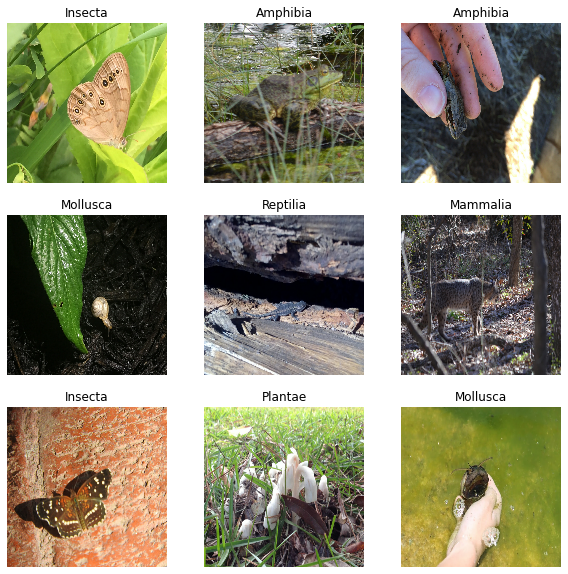

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [19]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))


Number of validation batches: 51
Number of test batches: 12


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)



In [21]:
#data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


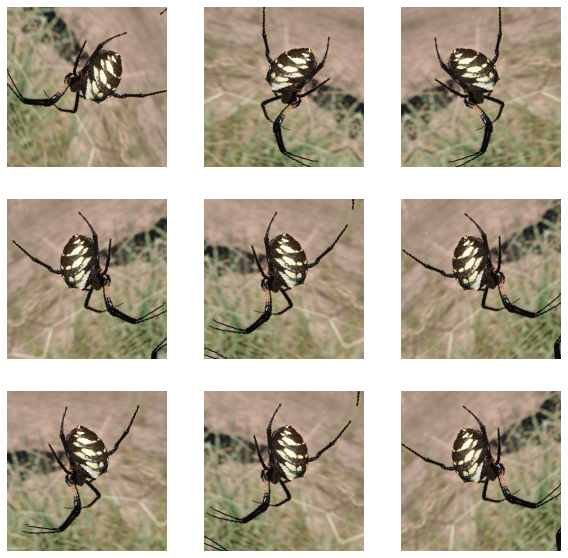

In [22]:
#see the augmented images
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [23]:
parameters = {
   
        'model':'resnet',
        #excluding output layer
        'dense_layers':1,
        'size_layer':32,
        #100% means no fine tuning, only pre training
        'layers_freeze':60,
        'dropout':0.2
        }
#(modelname,number of denselayers at top,size of each layer,percentage of frozen layer,dropout value)

In [28]:
#preprocessing requires the function name of the model 
classname="tf.keras.applications."
IMG_SHAPE = IMG_SIZE + (3,)
#defaults
modelnameproc="mobilenet_v2"
modelname="MobileNetV2"

attributes="(input_shape=IMG_SHAPE,include_top=False,weights='imagenet',pooling='avg')"
if parameters['model']=="resnet":
  print("Resnet chosen")
  modelnameproc="resnet_v2"
  modelname="ResNet50V2"
elif parameters['model']=="xception":
  print("Xception chosen")
  modelnameproc="xception"
  modelname="Xception"
elif parameters['model']=="inceptionres":
  print("InceptionResnet")
  modelname="InceptionResNetV2"
  modelnameproc="inception_resnet_v2"
elif parameters['model']=="mobilenet":
  print("Mobilenet chosen")
  modelname="MobileNetV2"
  modelnameproc="mobilenet_v2"
  
  #preprocess layer
preprocess_input = eval(classname+modelnameproc+".preprocess_input")
  #pretrained layers
base_model = eval(classname+modelname+attributes)
  #freezing the layers 
base_model.trainable = False
  #ouput layer 
  #10 since we have 10 classes 
prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
  #input layer 
inputs = tf.keras.Input(shape=IMG_SHAPE)
  #data augment
x = data_augmentation(inputs)
  #preprocess 
x = preprocess_input(x)

x = base_model(x, training=False)
  #add a dropout layer 
x = tf.keras.layers.Dropout(parameters['dropout'])(x)
  #add dense layers paired with dropouts 
for i in range(parameters['dense_layers']):
  x=tf.keras.layers.Dense(parameters['size_layer'],activation='relu')(x)
  x=tf.keras.layers.Dropout(parameters['dropout'])(x)
#output layer 
outputs = prediction_layer(x) 
model = tf.keras.Model(inputs, outputs)
  #set the learning rate 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  #number of epochs for pre training 
initial_epochs = 10 
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)
  #Fine tuning if present
if parameters['layers_freeze'] !=100:
    #unfreeze 
  base_model.trainable = True
    # Fine-tune from this layer onwards
  fine_tune_at = math.floor((parameters['layers_freeze']/100.0)*len(base_model.layers))
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
      #freeze 
    layer.trainable =  False
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
                metrics=['accuracy'])
    #fine tune epochs 
  fine_tune_epochs = 10
  total_epochs =  initial_epochs + fine_tune_epochs
  history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds)
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy :', test_acc)


Resnet chosen
94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/10
313/313 [==============================] - 129s 303ms/step - loss: 2.6778 - accuracy: 0.1246 - val_loss: 1.8495 - val_accuracy: 0.3571
Epoch 2/10
313/313 [==============================] - 94s 295ms/step - loss: 1.9525 - accuracy: 0.3099 - val_loss: 1.5184 - val_accuracy: 0.5012
Epoch 3/10
313/313 [==============================] - 91s 285ms/step - loss: 1.7326 - accuracy: 0.4040 - val_loss: 1.3588 - val_accuracy: 0.5600
Epoch 4/10
313/313 [==============================] - 91s 287ms/step - loss: 1.6311 - accuracy: 0.4386 - val_loss: 1.2820 - val_accuracy: 0.5681
Epoch 5/10
313/313 [==============================] - 91s 286ms/step - loss: 1.5440 - accuracy: 0.4786 - val_loss: 1.2429 - val_accuracy: 0.5922
Epoch 6/10
313/313 [==============================] - 93s 291ms/step - loss: 1.4906 - accuracy: 0.4968 - val_loss: 1.2049 - val_accuracy: 0.6046
Epoch 7/10
313/313 [==============================

In [ ]:
#if wandb required run the below blocks 

In [ ]:
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [2]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'model':{
            'values':['resnet']
        },
        #excluding output layer
        'dense_layers': {
            'values': [0,1,2]
        },
        'size_layer': {
            'values': [32, 64, 128]
        },
        #100% means no fine tuning, only pre training
        'layers_freeze':{
            'values': [60,70,80,100]
        
        },
        'dropout': {
            'values':[0.01,0.2,0.5,0.8]
        }

    }
}

In [19]:
!wandb login 781ea05d3016dc46e417672b13ee6d7047c00562 

301/313 [===========================>..] - ETA: 3s - loss: 9.5961 - accuracy: 0.0973

In [ ]:
sweep_id = wandb.sweep(sweep_config,entity='akceg', project="cs6910-assignment2-pretrain") 

Create sweep with ID: gjrr3879
Sweep URL: https://wandb.ai/akceg/cs6910-assignment2-pretrain/sweeps/gjrr3879


In [12]:
def train():
  #wandb setup
  wandb.init()
  config = wandb.config
  n=str(config.model)+"_tune"+str(config.layers_freeze)+"_layrs"+str(config.dense_layers)+"_size"+str(config.size_layer)+"_drop"+str(config.dropout)
  wandb.run.name=n
  #preprocessing requires the function name of the model 
  classname="tf.keras.applications."
  #defaults
  modelnameproc="mobilenet_v2"
  modelname="MobileNetV2"
  attributes="(input_shape=(160,160,3),include_top=False,weights='imagenet',pooling='avg')"
  if config.model=="resnet":
    print("Resnet chosen")
    modelnameproc="resnet_v2"
    modelname="ResNet50V2"
  elif config.model=="xception":
    print("Xception chosen")
    modelnameproc="xception"
    modelname="Xception"
  elif config.model=="inceptionres":
    print("InceptionResnet")
    modelname="InceptionResNetV2"
    modelnameproc="inception_resnet_v2"
  elif config.model=="mobilenet":
    print("Mobilenet chosen")
    modelname="MobileNetV2"
    modelnameproc="mobilenet_v2"
  
  #preprocess layer
  preprocess_input = eval(classname+modelnameproc+".preprocess_input")
  #pretrained layers
  base_model = eval(classname+modelname+attributes)
  #freezing the layers 
  base_model.trainable = False
  #ouput layer 
  prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
  #input layer 
  inputs = tf.keras.Input(shape=(160,160,3))
  #data augment
  x = data_augmentation(inputs)
  #preprocess 
  x = preprocess_input(x)

  x = base_model(x, training=False)
  #add a dropout layer 
  x = tf.keras.layers.Dropout(config.dropout)(x)
  #add dense layers paired with dropouts 
  for i in range(config.dense_layers):
    x=tf.keras.layers.Dense(config.size_layer,activation='relu')(x)
    x=tf.keras.layers.Dropout(config.dropout)(x)
  #output layer 
  outputs = prediction_layer(x) 
  model = tf.keras.Model(inputs, outputs)
  #set the learning rate 
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  #number of epochs for pre training 
  initial_epochs = 10 
  history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,callbacks=[WandbCallback()])
  #Fine tuning if present
  if config.layers_freeze !=100:
    #unfreeze 
    base_model.trainable = True
    # Fine-tune from this layer onwards
    fine_tune_at = math.floor((config.layers_freeze/100.0)*len(base_model.layers))
  # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      #freeze 
      layer.trainable =  False
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
                metrics=['accuracy'])
    #fine tune epochs 
    fine_tune_epochs = 10
    total_epochs =  initial_epochs + fine_tune_epochs
    history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds, callbacks=[WandbCallback()])
    test_loss, test_acc = model.evaluate(test_ds)
  print('Test accuracy :', test_acc)
  wandb.log({'test_accuracy': test_acc, 'test_loss': test_loss}) 


In [20]:
wandb.agent(sweep_id, train,count=9,project="cs6910-assignment2-pretrain")

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1z1215qv with config:
wandb: 	dense_layers: 2
wandb: 	dropout: 0.01
wandb: 	layers_freeze: 80
wandb: 	model: resnet
wandb: 	size_layer: 64


313/313 [==============================] - 118s 363ms/step - loss: 9.5358 - accuracy: 0.0976 - val_loss: 2.1798 - val_accuracy: 0.2277


Resnet chosen
Epoch 1/10
313/313 [==============================] - 86s 258ms/step - loss: 2.2660 - accuracy: 0.2111 - val_loss: 1.4200 - val_accuracy: 0.5433
Epoch 2/10
313/313 [==============================] - 81s 252ms/step - loss: 1.4922 - accuracy: 0.4935 - val_loss: 1.2166 - val_accuracy: 0.5897
Epoch 3/10
313/313 [==============================] - 79s 249ms/step - loss: 1.3194 - accuracy: 0.5555 - val_loss: 1.1536 - val_accuracy: 0.6145
Epoch 4/10
313/313 [==============================] - 80s 251ms/step - loss: 1.2400 - accuracy: 0.5786 - val_loss: 1.1046 - val_accuracy: 0.6355
Epoch 5/10
313/313 [==============================] - 80s 250ms/step - loss: 1.1972 - accuracy: 0.6016 - val_loss: 1.0773 - val_accuracy: 0.6405
Epoch 6/10
313/313 [==============================] - 80s 252ms/step - loss: 1.1666 - accuracy: 0.6083 - val_loss: 1.0726 - val_accuracy: 0.6355
Epoch 7/10
313/313 [==============================] - 80s 250ms/step - loss: 1.1115 - accuracy: 0.6205 - val_loss: 1

epoch,19
loss,0.52983
accuracy,0.82078
val_loss,1.08707
val_accuracy,0.68069
_runtime,1637
_timestamp,1618292098
_step,20
best_val_loss,0.95487
best_epoch,12
test_accuracy,0.68229


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
accuracy,▁▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▂▃
val_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇█▇█▇▇▇█▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: jp244dlz with config:
wandb: 	dense_layers: 0
wandb: 	dropout: 0.01
wandb: 	layers_freeze: 80
wandb: 	model: resnet
wandb: 	size_layer: 32


Resnet chosen
Epoch 1/10
313/313 [==============================] - 87s 262ms/step - loss: 2.5653 - accuracy: 0.2059 - val_loss: 1.6008 - val_accuracy: 0.4728
Epoch 2/10
313/313 [==============================] - 81s 254ms/step - loss: 1.7001 - accuracy: 0.4439 - val_loss: 1.3572 - val_accuracy: 0.5538
Epoch 3/10
313/313 [==============================] - 80s 252ms/step - loss: 1.4650 - accuracy: 0.5131 - val_loss: 1.2313 - val_accuracy: 0.5934
Epoch 4/10
313/313 [==============================] - 80s 250ms/step - loss: 1.3690 - accuracy: 0.5468 - val_loss: 1.1977 - val_accuracy: 0.6095
Epoch 5/10
313/313 [==============================] - 80s 251ms/step - loss: 1.2948 - accuracy: 0.5639 - val_loss: 1.1482 - val_accuracy: 0.6194
Epoch 6/10
313/313 [==============================] - 81s 252ms/step - loss: 1.2802 - accuracy: 0.5776 - val_loss: 1.1304 - val_accuracy: 0.6306
Epoch 7/10
313/313 [==============================] - 80s 252ms/step - loss: 1.2368 - accuracy: 0.5862 - val_loss: 1

epoch,19
loss,0.5045
accuracy,0.82638
val_loss,1.05969
val_accuracy,0.69802
_runtime,1635
_timestamp,1618293746
_step,20
best_val_loss,0.96669
best_epoch,15
test_accuracy,0.67448


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁
accuracy,▁▃▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇███
val_loss,█▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂
val_accuracy,▁▄▅▅▆▆▆▆▇▆▇▇▇███████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: 20j5rjpq with config:
wandb: 	dense_layers: 1
wandb: 	dropout: 0.01
wandb: 	layers_freeze: 70
wandb: 	model: resnet
wandb: 	size_layer: 32


Resnet chosen
Epoch 1/10
313/313 [==============================] - 84s 253ms/step - loss: 2.3068 - accuracy: 0.2027 - val_loss: 1.5911 - val_accuracy: 0.4796
Epoch 2/10
313/313 [==============================] - 80s 250ms/step - loss: 1.6168 - accuracy: 0.4540 - val_loss: 1.3389 - val_accuracy: 0.5650
Epoch 3/10
313/313 [==============================] - 79s 249ms/step - loss: 1.4284 - accuracy: 0.5239 - val_loss: 1.2462 - val_accuracy: 0.5978
Epoch 4/10
313/313 [==============================] - 80s 250ms/step - loss: 1.3252 - accuracy: 0.5554 - val_loss: 1.1864 - val_accuracy: 0.6126
Epoch 5/10
313/313 [==============================] - 79s 249ms/step - loss: 1.2753 - accuracy: 0.5739 - val_loss: 1.1659 - val_accuracy: 0.6200
Epoch 6/10
313/313 [==============================] - 80s 250ms/step - loss: 1.2459 - accuracy: 0.5864 - val_loss: 1.1338 - val_accuracy: 0.6349
Epoch 7/10
313/313 [==============================] - 80s 249ms/step - loss: 1.1921 - accuracy: 0.5971 - val_loss: 1

epoch,19
loss,0.50245
accuracy,0.83218
val_loss,1.03517
val_accuracy,0.69059
_runtime,1630
_timestamp,1618295387
_step,20
best_val_loss,0.96689
best_epoch,13
test_accuracy,0.68229


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▄▄▄▄▃▃▂▂▂▂▁▁▁
accuracy,▁▃▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇███
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▂▂
val_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇███████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: stra91iq with config:
wandb: 	dense_layers: 1
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 60
wandb: 	model: resnet
wandb: 	size_layer: 64


Resnet chosen
Epoch 1/10
313/313 [==============================] - 85s 256ms/step - loss: 2.6027 - accuracy: 0.1960 - val_loss: 1.4786 - val_accuracy: 0.5062
Epoch 2/10
313/313 [==============================] - 81s 252ms/step - loss: 1.7212 - accuracy: 0.4099 - val_loss: 1.2678 - val_accuracy: 0.5804
Epoch 3/10
313/313 [==============================] - 80s 251ms/step - loss: 1.5422 - accuracy: 0.4706 - val_loss: 1.1864 - val_accuracy: 0.6033
Epoch 4/10
313/313 [==============================] - 80s 251ms/step - loss: 1.4615 - accuracy: 0.5086 - val_loss: 1.1658 - val_accuracy: 0.6120
Epoch 5/10
313/313 [==============================] - 80s 250ms/step - loss: 1.3859 - accuracy: 0.5310 - val_loss: 1.1035 - val_accuracy: 0.6324
Epoch 6/10
313/313 [==============================] - 79s 247ms/step - loss: 1.3638 - accuracy: 0.5400 - val_loss: 1.0994 - val_accuracy: 0.6423
Epoch 7/10
313/313 [==============================] - 79s 247ms/step - loss: 1.3282 - accuracy: 0.5494 - val_loss: 1

epoch,19
loss,0.7088
accuracy,0.75588
val_loss,0.93442
val_accuracy,0.69554
_runtime,1650
_timestamp,1618297050
_step,20
best_val_loss,0.90669
best_epoch,15
test_accuracy,0.70052


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁
accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
val_loss,█▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▆▆▇▇████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: qxa7l6x3 with config:
wandb: 	dense_layers: 1
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: resnet
wandb: 	size_layer: 64


Resnet chosen
Epoch 1/10
313/313 [==============================] - 89s 271ms/step - loss: 2.4264 - accuracy: 0.2211 - val_loss: 1.4327 - val_accuracy: 0.5248
Epoch 2/10
313/313 [==============================] - 88s 275ms/step - loss: 1.6847 - accuracy: 0.4217 - val_loss: 1.2603 - val_accuracy: 0.5730
Epoch 3/10
313/313 [==============================] - 88s 278ms/step - loss: 1.5429 - accuracy: 0.4816 - val_loss: 1.1726 - val_accuracy: 0.6015
Epoch 4/10
313/313 [==============================] - 86s 271ms/step - loss: 1.4565 - accuracy: 0.5068 - val_loss: 1.1377 - val_accuracy: 0.6120
Epoch 5/10
313/313 [==============================] - 88s 278ms/step - loss: 1.3908 - accuracy: 0.5241 - val_loss: 1.1197 - val_accuracy: 0.6194
Epoch 6/10
313/313 [==============================] - 85s 267ms/step - loss: 1.3792 - accuracy: 0.5331 - val_loss: 1.0859 - val_accuracy: 0.6355
Epoch 7/10
313/313 [==============================] - 88s 277ms/step - loss: 1.3397 - accuracy: 0.5486 - val_loss: 1

epoch,19
loss,0.7336
accuracy,0.75048
val_loss,0.93525
val_accuracy,0.70792
_runtime,1836
_timestamp,1618298901
_step,20
best_val_loss,0.91588
best_epoch,15
test_accuracy,0.70573


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁
accuracy,▁▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇███
val_loss,█▆▄▄▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▅▅▆▆▆▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: tht480yh with config:
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: resnet
wandb: 	size_layer: 128


Resnet chosen
Epoch 1/10
313/313 [==============================] - 84s 253ms/step - loss: 2.4600 - accuracy: 0.1694 - val_loss: 1.4910 - val_accuracy: 0.5210
Epoch 2/10
313/313 [==============================] - 80s 251ms/step - loss: 1.7251 - accuracy: 0.4162 - val_loss: 1.2260 - val_accuracy: 0.6083
Epoch 3/10
313/313 [==============================] - 80s 251ms/step - loss: 1.5489 - accuracy: 0.4791 - val_loss: 1.1728 - val_accuracy: 0.6231
Epoch 4/10
313/313 [==============================] - 79s 249ms/step - loss: 1.4541 - accuracy: 0.5070 - val_loss: 1.1193 - val_accuracy: 0.6374
Epoch 5/10
313/313 [==============================] - 79s 248ms/step - loss: 1.4281 - accuracy: 0.5211 - val_loss: 1.0936 - val_accuracy: 0.6491
Epoch 6/10
313/313 [==============================] - 81s 253ms/step - loss: 1.3399 - accuracy: 0.5440 - val_loss: 1.0762 - val_accuracy: 0.6528
Epoch 7/10
313/313 [==============================] - 80s 252ms/step - loss: 1.3250 - accuracy: 0.5594 - val_loss: 1

epoch,19
loss,0.77637
accuracy,0.73537
val_loss,0.93872
val_accuracy,0.69802
_runtime,1644
_timestamp,1618300558
_step,20
best_val_loss,0.9128
best_epoch,18
test_accuracy,0.6901


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇████
val_loss,█▅▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇██████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: 3rmpxllt with config:
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 60
wandb: 	model: resnet
wandb: 	size_layer: 128


Resnet chosen
Epoch 1/10
313/313 [==============================] - 91s 277ms/step - loss: 2.4255 - accuracy: 0.1828 - val_loss: 1.5022 - val_accuracy: 0.5130
Epoch 2/10
313/313 [==============================] - 87s 274ms/step - loss: 1.7423 - accuracy: 0.4058 - val_loss: 1.2529 - val_accuracy: 0.5835
Epoch 3/10
313/313 [==============================] - 86s 271ms/step - loss: 1.5596 - accuracy: 0.4698 - val_loss: 1.1759 - val_accuracy: 0.6101
Epoch 4/10
313/313 [==============================] - 87s 273ms/step - loss: 1.4470 - accuracy: 0.5100 - val_loss: 1.1253 - val_accuracy: 0.6225
Epoch 5/10
313/313 [==============================] - 87s 273ms/step - loss: 1.3913 - accuracy: 0.5349 - val_loss: 1.0924 - val_accuracy: 0.6411
Epoch 6/10
313/313 [==============================] - 86s 269ms/step - loss: 1.3686 - accuracy: 0.5445 - val_loss: 1.0739 - val_accuracy: 0.6510
Epoch 7/10
313/313 [==============================] - 88s 278ms/step - loss: 1.3247 - accuracy: 0.5528 - val_loss: 1

epoch,19
loss,0.77638
accuracy,0.73737
val_loss,0.88215
val_accuracy,0.7104
_runtime,1721
_timestamp,1618302288
_step,20
best_val_loss,0.88127
best_epoch,14
test_accuracy,0.69792


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇████
val_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▆▆▆▆▆▇▇▇██████
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r7r4upnl with config:
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 80
wandb: 	model: resnet
wandb: 	size_layer: 64


Resnet chosen
Epoch 1/10
313/313 [==============================] - 84s 253ms/step - loss: 2.4515 - accuracy: 0.1561 - val_loss: 1.7392 - val_accuracy: 0.4511
Epoch 2/10
313/313 [==============================] - 80s 251ms/step - loss: 1.9173 - accuracy: 0.3297 - val_loss: 1.3937 - val_accuracy: 0.5675
Epoch 3/10
313/313 [==============================] - 79s 249ms/step - loss: 1.7107 - accuracy: 0.4179 - val_loss: 1.2708 - val_accuracy: 0.5910
Epoch 4/10
313/313 [==============================] - 80s 250ms/step - loss: 1.5958 - accuracy: 0.4662 - val_loss: 1.1855 - val_accuracy: 0.6207
Epoch 5/10
313/313 [==============================] - 80s 252ms/step - loss: 1.5267 - accuracy: 0.4917 - val_loss: 1.1550 - val_accuracy: 0.6238
Epoch 6/10
313/313 [==============================] - 79s 248ms/step - loss: 1.4851 - accuracy: 0.5016 - val_loss: 1.1383 - val_accuracy: 0.6269
Epoch 7/10
313/313 [==============================] - 80s 251ms/step - loss: 1.4293 - accuracy: 0.5275 - val_loss: 1

epoch,19
loss,0.89511
accuracy,0.70387
val_loss,0.94063
val_accuracy,0.69616
_runtime,1628
_timestamp,1618303937
_step,20
best_val_loss,0.93098
best_epoch,17
test_accuracy,0.69271


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
accuracy,▁▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▆▆▆▇▇▇██▇████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁


wandb: Agent Starting Run: bero2ldo with config:
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: resnet
wandb: 	size_layer: 128


Resnet chosen
Epoch 1/10
313/313 [==============================] - 84s 252ms/step - loss: 2.4803 - accuracy: 0.1785 - val_loss: 1.4856 - val_accuracy: 0.5229
Epoch 2/10
313/313 [==============================] - 79s 248ms/step - loss: 1.7503 - accuracy: 0.3932 - val_loss: 1.2285 - val_accuracy: 0.5947
Epoch 3/10
313/313 [==============================] - 80s 250ms/step - loss: 1.5386 - accuracy: 0.4748 - val_loss: 1.1724 - val_accuracy: 0.6089
Epoch 4/10
313/313 [==============================] - 79s 249ms/step - loss: 1.4515 - accuracy: 0.5020 - val_loss: 1.1160 - val_accuracy: 0.6256
Epoch 5/10
313/313 [==============================] - 80s 249ms/step - loss: 1.4105 - accuracy: 0.5185 - val_loss: 1.0927 - val_accuracy: 0.6349
Epoch 6/10
313/313 [==============================] - 79s 247ms/step - loss: 1.3553 - accuracy: 0.5394 - val_loss: 1.0652 - val_accuracy: 0.6516
Epoch 7/10
313/313 [==============================] - 80s 250ms/step - loss: 1.3420 - accuracy: 0.5439 - val_loss: 1

epoch,19
loss,0.76851
accuracy,0.74037
val_loss,0.90137
val_accuracy,0.7104
_runtime,1638
_timestamp,1618305586
_step,20
best_val_loss,0.885
best_epoch,16
test_accuracy,0.71354


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
accuracy,▁▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
val_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
